In [1]:
from __future__ import annotations

from pathlib import Path
import sys
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

# --- Resolve repo root ---
REPO_ROOT = Path.cwd().resolve()
if REPO_ROOT.name.lower() == "notebooks":
    REPO_ROOT = REPO_ROOT.parent

assert (REPO_ROOT / "src").exists(), "Not in resilient-housing-bayes repo"

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

print("Repo root:", REPO_ROOT)

Repo root: C:\Users\C.Price\Habnetic\resilient-housing-bayes


In [2]:
# --- Load posterior (saved in inference notebook) ---
IDATA_PATH = REPO_ROOT / "outputs" / "rtm" / "inference" / "rtm_damage_v1b_logistic_idata.nc"
assert IDATA_PATH.exists(), f"Missing idata: {IDATA_PATH}"

idata = az.from_netcdf(IDATA_PATH)
print("Loaded idata from:", IDATA_PATH)

# --- Load exposure (canonical artifact) ---
E_PATH = REPO_ROOT / "outputs" / "rtm" / "water_exposure_Ehat_v0.parquet"
assert E_PATH.exists(), f"Missing exposure parquet: {E_PATH}"
E_df = pd.read_parquet(E_PATH)[["bldg_id", "E_hat"]]

# --- Load hazard via canonical loader ---
from src.rtm.io_hazard import load_rtm_pluvial_v1_buildings
haz_df = load_rtm_pluvial_v1_buildings()

print("Exposure rows:", len(E_df))
print("Hazard rows:", len(haz_df))

# --- Merge baseline dataset ---
df = E_df.merge(haz_df, on="bldg_id", validate="one_to_one")
print("Merged rows:", len(df))
df.head()

Loaded idata from: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\inference\rtm_damage_v1b_logistic_idata.nc
Exposure rows: 221324
Hazard rows: 221324
Merged rows: 221324


,bldg_id,E_hat,H_pluvial_v1_mm
0,305012,0.536838,25.422161
1,313960,0.677579,25.418823
2,313263,0.251841,25.423113
3,310491,0.189019,25.424500
4,313127,-0.292821,25.423491


In [3]:
idata = az.from_netcdf(IDATA_PATH)

post = idata.posterior
for v in ["alpha", "beta_E", "beta_H"]:
    assert v in post.data_vars, f"Missing {v} in posterior"

alpha = post["alpha"].values.reshape(-1)   # (S,)
beta_E = post["beta_E"].values.reshape(-1)
beta_H = post["beta_H"].values.reshape(-1)

S = alpha.shape[0]
print("Posterior draws:", S)

Posterior draws: 1000


In [4]:
# Exposure
E_df = pd.read_parquet(E_PATH)[["bldg_id", "E_hat"]]

# Hazard (canonical loader, no file path needed)
from src.rtm.io_hazard import load_rtm_pluvial_v1_buildings
H_df = load_rtm_pluvial_v1_buildings()[["bldg_id", "H_pluvial_v1_mm"]]

# Merge
df = E_df.merge(H_df, on="bldg_id", validate="one_to_one")
print("Rows:", len(df))
df.head()

Rows: 221324


,bldg_id,E_hat,H_pluvial_v1_mm
0,305012,0.536838,25.422161
1,313960,0.677579,25.418823
2,313263,0.251841,25.423113
3,310491,0.189019,25.424500
4,313127,-0.292821,25.423491


In [5]:
E = df["E_hat"].to_numpy()
H = df["H_pluvial_v1_mm"].to_numpy()

E_std = (E - E.mean()) / (E.std() + 1e-12)
H_std = (H - H.mean()) / (H.std() + 1e-12)

df["E_std"] = E_std
df["H_std"] = H_std

df[["E_std", "H_std"]].describe()

,E_std,H_std
count,2.213240e+05,221324.000000
mean,3.595669e-18,-0.000001
std,1.000002e+00,1.000002
min,-3.441542e+00,-1.334173
25%,-4.709328e-01,-0.781009
50%,3.721504e-01,-0.127685
75%,6.694667e-01,0.408261
max,2.699387e+00,4.283368


In [6]:
# logits: (S, N)
logits = alpha[:, None] + beta_E[:, None] * df["E_std"].to_numpy()[None, :] + beta_H[:, None] * df["H_std"].to_numpy()[None, :]

# sigmoid safely
p = 1.0 / (1.0 + np.exp(-logits))

print("p shape:", p.shape)
print("p min/max:", float(p.min()), float(p.max()))

p shape: (1000, 221324)
p min/max: 0.00015969531517379367 0.8719351147569169


In [7]:
N = len(df)
p_mean = np.empty(N, dtype=np.float32)
p_sd = np.empty(N, dtype=np.float32)

X_E = df["E_std"].to_numpy()
X_H = df["H_std"].to_numpy()

chunk = 20000
for i0 in range(0, N, chunk):
    i1 = min(N, i0 + chunk)
    logits_c = alpha[:, None] + beta_E[:, None] * X_E[None, i0:i1] + beta_H[:, None] * X_H[None, i0:i1]
    p_c = 1.0 / (1.0 + np.exp(-logits_c))
    p_mean[i0:i1] = p_c.mean(axis=0)
    p_sd[i0:i1] = p_c.std(axis=0)

df["p_mean"] = p_mean
df["p_sd"] = p_sd

df[["p_mean", "p_sd"]].describe()

,p_mean,p_sd
count,221324.000000,221324.000000
mean,0.077432,0.005879
std,0.079035,0.005701
min,0.000646,0.000266
25%,0.024814,0.002933
50%,0.054756,0.004269
75%,0.100106,0.006414
max,0.767902,0.050214


In [8]:
k = 5000

# rank is based on p (higher = riskier)
# We'll compute top-k probability by chunking draws to avoid huge memory
X_E = df["E_std"].to_numpy()
X_H = df["H_std"].to_numpy()
N = len(df)

topk_counts = np.zeros(N, dtype=np.int32)

draw_chunk = 200  # handle 200 draws at a time
for s0 in range(0, S, draw_chunk):
    s1 = min(S, s0 + draw_chunk)
    a = alpha[s0:s1]
    bE = beta_E[s0:s1]
    bH = beta_H[s0:s1]

    logits_c = a[:, None] + bE[:, None] * X_E[None, :] + bH[:, None] * X_H[None, :]
    p_c = 1.0 / (1.0 + np.exp(-logits_c))  # (s1-s0, N)

    # indices of top-k per draw
    idx = np.argpartition(p_c, -k, axis=1)[:, -k:]  # (chunk, k)

    # accumulate counts
    for row in idx:
        topk_counts[row] += 1

topk_prob = topk_counts / float(S)
df["topk_prob"] = topk_prob

df["topk_prob"].describe()

count    221324.000000
mean          0.022591
std           0.145292
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: topk_prob, dtype: float64

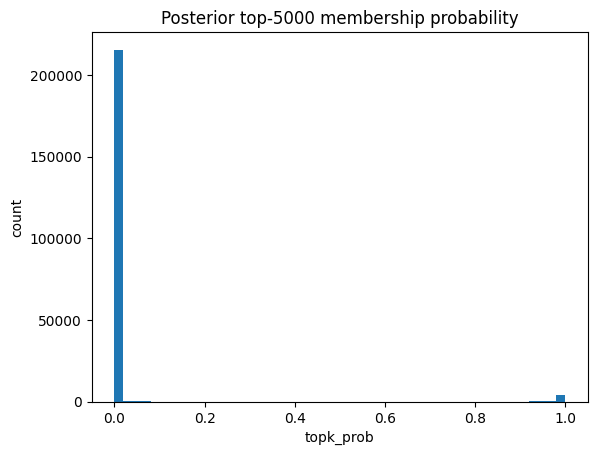

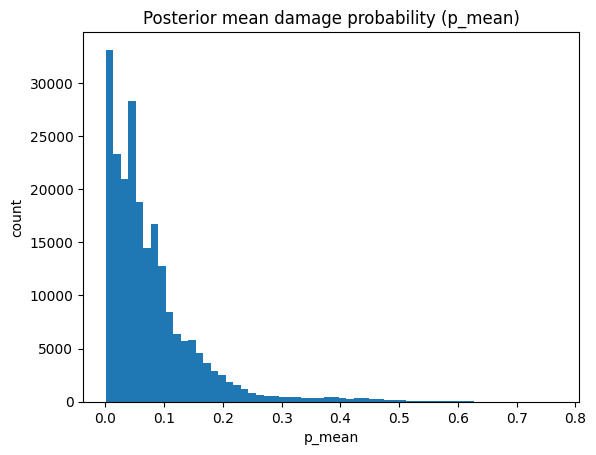

In [9]:
plt.figure()
plt.hist(df["topk_prob"], bins=50)
plt.title(f"Posterior top-{k} membership probability")
plt.xlabel("topk_prob")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(df["p_mean"], bins=60)
plt.title("Posterior mean damage probability (p_mean)")
plt.xlabel("p_mean")
plt.ylabel("count")
plt.show()

In [10]:
from pathlib import Path

REPO_ROOT = Path.cwd().resolve()
if REPO_ROOT.name.lower() == "notebooks":
    REPO_ROOT = REPO_ROOT.parent

OUT_DIR = REPO_ROOT / "outputs" / "rtm" / "decision_stability" / "v1b"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# If not defined yet:
k = 10000

print("REPO_ROOT:", REPO_ROOT)
print("OUT_DIR:", OUT_DIR)
print("k:", k)

REPO_ROOT: C:\Users\C.Price\Habnetic\resilient-housing-bayes
OUT_DIR: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b
k: 10000


In [11]:
out_path = OUT_DIR / f"rtm_decision_stability_v1b_top{k}.parquet"

df_out = df[
    ["bldg_id", "E_hat", "H_pluvial_v1_mm", "p_mean", "p_sd", "topk_prob"]
].copy()

df_out.to_parquet(out_path, index=False)

print("Saved:", out_path)
print("Rows:", len(df_out))

Saved: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b\rtm_decision_stability_v1b_top10000.parquet
Rows: 221324


In [12]:
qgis_path = OUT_DIR / f"rtm_topkprob_v1b_top{k}_qgis.parquet"
df_out[["bldg_id", "topk_prob", "p_mean", "p_sd"]].to_parquet(qgis_path, index=False)
print("Saved QGIS join table:", qgis_path)

Saved QGIS join table: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b\rtm_topkprob_v1b_top10000_qgis.parquet


In [13]:
df_out["topk_prob"].describe()

count    221324.000000
mean          0.022591
std           0.145292
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: topk_prob, dtype: float64

In [18]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

REPO_ROOT = Path.cwd().resolve().parents[0]
DECISION_DIR = REPO_ROOT / "outputs" / "rtm" / "decision_stability" / "v1b"

print("DECISION_DIR:", DECISION_DIR)
print("Exists:", DECISION_DIR.exists())
print("Files:", [p.name for p in sorted(DECISION_DIR.glob("rtm_decision_stability_v1b_top*.parquet"))])

k_values = [1000, 2500, 5000, 10000]

results = []

for k in k_values:
    path = DECISION_DIR / f"rtm_decision_stability_v1b_top{k}.parquet"
    df_k = pd.read_parquet(path)

    N = len(df_k)

    mean_topk = df_k["topk_prob"].mean()
    unstable_share = (df_k["topk_prob"] > 0.2).mean()

    results.append({
        "k": k,
        "mean_topk_prob": mean_topk,
        "unstable_share_0_2": unstable_share,
        "k_over_N": k / N
    })

summary = pd.DataFrame(results)
summary

DECISION_DIR: C:\Users\C.Price\Habnetic\resilient-housing-bayes\outputs\rtm\decision_stability\v1b
Exists: True
Files: ['rtm_decision_stability_v1b_top1000.parquet', 'rtm_decision_stability_v1b_top10000.parquet', 'rtm_decision_stability_v1b_top2500.parquet', 'rtm_decision_stability_v1b_top5000.parquet']


,k,mean_topk_prob,unstable_share_0_2,k_over_N
0,1000,0.022591,0.024037,0.004518
1,2500,0.022591,0.024037,0.011296
2,5000,0.022591,0.024037,0.022591
3,10000,0.022591,0.024037,0.045183


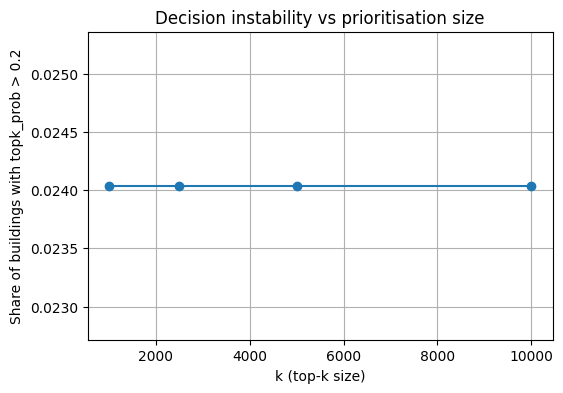

In [19]:
plt.figure(figsize=(6,4))
plt.plot(summary["k"], summary["unstable_share_0_2"], marker="o")
plt.xlabel("k (top-k size)")
plt.ylabel("Share of buildings with topk_prob > 0.2")
plt.title("Decision instability vs prioritisation size")
plt.grid(True)
plt.show()

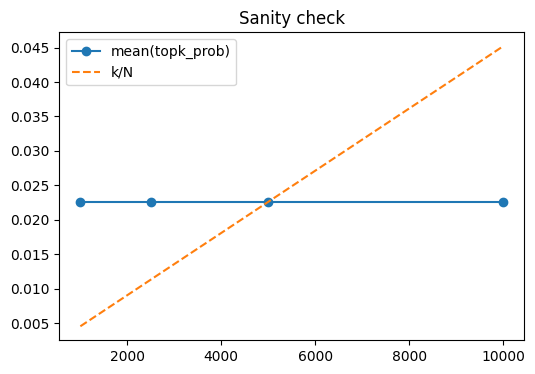

In [20]:
plt.figure(figsize=(6,4))
plt.plot(summary["k"], summary["mean_topk_prob"], marker="o", label="mean(topk_prob)")
plt.plot(summary["k"], summary["k_over_N"], linestyle="--", label="k/N")
plt.legend()
plt.title("Sanity check")
plt.show()